<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/SIMULACI%C3%93_A/Bueno_girem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bueno aquest programa serivirà per girar un vector posició vist des del centre de la Terra al voltant d'un eix arbitrari (en aquest cas serà l'eix de rotació de la Terra evidentment) durant un temps també arbitrari que evidentment sera 24h (em vull matar).

Usarem la fòrmula de Rodrigues que diu:

$\vec{v}' = \vec{v}cos(\omega t)\ + \ (\hat{k} \times \vec{v})sin(\omega t)\ +\ \hat{k}(\hat{k}\cdotp \vec{v})(1-cos(\omega t))$

On tenim que $\vec{v}$ és el vector que volem rotar, $\hat{k}$ és el vector unitari al voltant del qual volem rotar $\vec{v}$ i $\omega t$ és la velocitat angular amb la que el vector $\vec{v}$ gira al voltant de $\hat{k}$. Naturalment $\vec{v}'$ serà el vector girat a un temps $t$.

Per altre banda definirem dos angles, $\theta$ i $\phi $:

$
  \qquad \theta $ serà l'angle de l'eix de rotació de la Terra respecte la vertical; $\theta = 23,43333333333333º$

$
  \qquad \phi $ serà l'angle que uneix l'eix de rotació de la Terra amb el vector posició (des del centre de la Terra) amb Bellaterra; $\qquad \phi = 41º\ 30'\ 21''$


Per altre considerarem el següent (de moment):

$
  \qquad 1)$ El "costat fosc" de la Terra tindrà incidència nul·la (tindrà foscor total)

$
  \qquad 2)$ Suposarem $\theta$ constant per escales de temps molt menors a $10^4$ anys

considerarem que el vector $\vec{v}$ per $t=0$ serà: $\vec{v} = R(sin(\theta\ + \phi),0,cos(\theta\ + \phi))$ que serà el vector que volem rotar.

L'eix de la Terra tindrà coordenades $\hat{k} = (sin(\theta),0,cos(\theta))$

Ens queda només doncs fer el càlculs, si els fem ens queda una monstruositat de vector però funciona:

$$
\vec{v}'=\begin{pmatrix} R[\sin(\theta\ + \phi)cos(\omega t)\ + \ sin(\theta) \left[sin(\theta)sin(\theta\ +\ \phi)\ + \ cos(\theta)cos(\theta\ + \ \phi)]\right (1-cos(\omega t))]\\
 R[cos(\theta)sin(\theta\ +\ \phi) - sin(\theta)cos(\theta\ + \ \phi)]sin(\omega t) \\
 R[cos(\theta\ + \ \phi)cos(\omega t)\ +\ cos(\theta)\left[sin(\theta)sin(\theta\ + \ \phi)\ + \ cos(\theta)cos(\theta\ +\ \phi)]\right(1-cos(\omega t))]
\end{pmatrix}
$$

I ja estaria només fem discretització de les 24 hores del dia ja tenim el vector rotat (R és la distància des del centre de la Terra fins Bellaterra ).

Passos per resoldre el problema amb Runge–Kutta 4:

1. Escriure l’equació diferencial del problema:
   - El vector posició `v(t)` gira al voltant d’un eix fix `k_unit` amb velocitat angular `omega`.
   - L’equació és: `dv/dt = omega * (k_unit × v)`.

2. Definir les constants del model:
   - Converteix els angles `theta` i `phi` de graus a radians.
   - Fixa el radi `R` (distància del centre de la Terra a Bellaterra).
   - Fixa el període `T = 24 h` (en segons) i calcula `omega = 2*pi/T`.

3. Definir l’eix de rotació i el vector inicial:
   - `k_unit = (sin(theta), 0, cos(theta))` i normalitzar-lo per si de cas.
   - Vector posició inicial:
     `v0 = R * (sin(theta + phi), 0, cos(theta + phi))`.

4. Escriure la funció del camp de derivades `f(t, v)`:
   - En codi: `f(t, v) = omega * np.cross(k_unit, v)`.
   - Aquesta funció torna `dv/dt` per a un temps `t` i vector `v`.

5. Implementar una funció que faci un pas de Runge–Kutta 4 (RK4):
   - Donats `t`, `v` i `dt`, calcula `k1`, `k2`, `k3`, `k4` i retorna el nou vector `v_nou`.

6. Discretitzar el dia:
   - Triar un nombre de passos `N` (per exemple 1000).
   - Definir `dt = T/N`.
   - Crear arrays per guardar el temps `t_n` i els vectors `v_n`.

7. Fer el bucle d’integració:
   - Inicialitzar `t = 0`, `v = v0`.
   - Per cada pas:
     - Actualitzar `v` amb un pas de RK4.
     - Actualitzar `t = t + dt`.
     - Guardar `t` i `v` als arrays.

8. (Opcional però útil) Renormalitzar `v` a cada pas:
   - Per mantenir el mòdul constant: `v = R * v / ||v||`.

9. (Opcional) Determinar si Bellaterra està al costat fosc o il·luminat:
   - Definir un vector unitari `s_unit` que apunti cap al Sol.
   - En cada instant:
     - Calcular el producte escalar `v · s_unit`.
     - Si és > 0 → costat il·luminat; si és ≤ 0 → costat fosc (incidència nul·la).


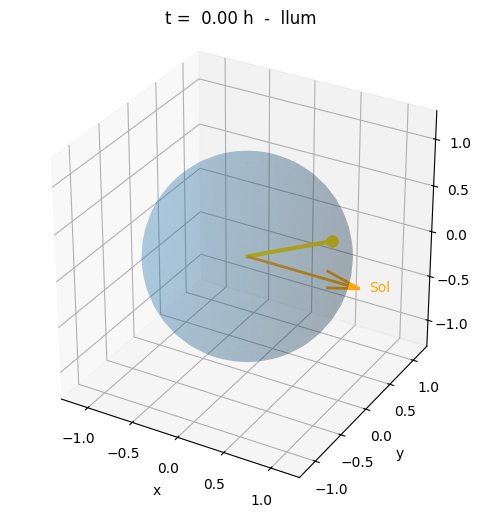

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50  # per exemple


# Constants
graus = np.pi / 180
theta = 23.43333333333333 * graus  # inclinació eix Terra
phi = (41 + 30/60 + 21/3600) * graus  # latitud de Bellaterra 41º 30' 21''
R = 1   # radi de la Terra normalitzat
T = 24 * 3600  # període en segons
omega = 2 * np.pi / T  # velocitat angular en rad/s

# Eix de rotació unitari
k = np.array([np.sin(theta), 0, np.cos(theta)])
k_unit = k / np.linalg.norm(k)

# Vector posició inicial v(0)
v0 = R * np.array([np.sin(theta + phi), 0, np.cos(theta + phi)])

# Direcció cap al Sol
s_unit = np.array([1, 0, 0])

# Definició EDO
def f(t, v):
    return omega * np.cross(k_unit, v)

# Pas de RK4
def rk4_pas(f, t, v, dt):
    k1 = f(t, v)
    k2 = f(t + 0.5*dt, v + 0.5*dt*k1)
    k3 = f(t + 0.5*dt, v + 0.5*dt*k2)
    k4 = f(t + dt,       v + dt*k3)
    return v + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Paràmetres de la integració
N = 200
dt = T / N
t = 0.0
v = v0.copy()
ts = np.zeros(N+1)
vs = np.zeros((N+1, 3))
ts[0] = t
vs[0] = v

for n in range(N):
    v = rk4_pas(f, t, v, dt)
    t += dt
    ts[n+1] = t
    vs[n+1] = v # vs[n] vector posició de Bellaterra després de t segons

    # Renormalitzar per mantenir |v| = R (per si deriva una mica)
    v = R * v / np.linalg.norm(v)
    t += dt
    ts[n+1] = t
    vs[n+1] = v

# Animació
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Esfera (Terra)
u = np.linspace(0, 2*np.pi, 50)
v_ang = np.linspace(0, np.pi, 25)
x_esfera = R * np.outer(np.cos(u), np.sin(v_ang))
y_esfera = R * np.outer(np.sin(u), np.sin(v_ang))
z_esfera = R * np.outer(np.ones_like(u), np.cos(v_ang))
ax.plot_surface(x_esfera, y_esfera, z_esfera, alpha=0.2)

# Fletxa cap al Sol
ax.quiver(0, 0, 0, 1.2*R, 0, 0, color='orange', linewidth=2)
ax.text(1.3*R, 0, 0, "Sol", color='orange')

# Línia i punt per al vector posició
line, = ax.plot([], [], [], lw=3)
point, = ax.plot([], [], [], 'o', markersize=8)

# Límits dels eixos
lim = 1.3 * R
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('')

# Fer que l’escala sigui igual en els tres eixos
ax.set_box_aspect([1, 1, 1])

def update(frame):
    v = vs[frame]

    # coordenades del vector
    x = [0, v[0]]
    y = [0, v[1]]
    z = [0, v[2]]

    line.set_data(x, y)
    line.set_3d_properties(z)

    point.set_data([v[0]], [v[1]])
    point.set_3d_properties([v[2]])

    # costat il·luminat o fosc
    cos_alpha = np.dot(v, s_unit) / (np.linalg.norm(v) * np.linalg.norm(s_unit))
    if cos_alpha > 0: # si el cosinus és positiu és de dia
        color = 'gold'
        estat = 'llum'
    else:
        color = 'black'
        estat = 'foscor'

    line.set_color(color)
    point.set_color(color)

    # temps en hores (no és la hora del dia!)
    hores = 24 * frame / (len(vs) - 1)
    ax.set_title(f"t = {hores:5.2f} h  -  {estat}")

    return line, point

# Animació
anim = FuncAnimation(fig, update, frames=len(ts), interval=40, blit=False)

# Per veure'l inline al Colab:
# HTML(anim.to_jshtml())

# Per descarregar-lo
anim.save('rotacio_vector_bellaterra.mp4', writer='ffmpeg', fps=25)




In [2]:
#en fi ara ve la part que trobem l'angle d'incidencia amb el sol
#suposant que el vector normal al pla de les plaques solars és paral·lel al vector que uneix el centre de la terra amb bellaterra

#necessitem les posicions a la Terra, agafaré durant un any la posició de la Terra cada hora, o sigui 365*24 posicions (de moment Euler que es el que funca)
import numpy as np
import matplotlib.pyplot as plt
import copy

# Dades en unitats del SI
G= 6.67430e-11
m_sol= 1.98847e30
m_terra= 5.97219e24
m_lluna= 7.349e22
m_mart= 6.4171e23

# Condicions inicials (en cartesianes)
# L'origen és el baricentre del sistema solar
# Format: [x,y,z,vx,vy,vz]
# Inici a les 04:42 del 21 de Juliol del 2025 (solstici d'estiu)
# Això és per el temps central Europeu, per tant hi ha un lleuger error
# Ja que no està a Bellaterra/Barcelona exactament.

#Posicions en kilometres i velocitats en km/s
lluna= np.array([-1.081554325966438E+06, -1.526346829987447E+08, 5.289505218940973E+04,
 2.874182090220137E+01, 6.308874791782940E-01, 6.961580076988511E-02])

terra= np.array([-1.393448650322997E+06, -1.528245787749783E+08, 3.246810235627741E+04,
 2.932512160332670E+01, -2.663812783881785E-01, -1.233690374052812E-03])

sol= np.array([-6.714001826750380E+05, -8.034375730918228E+05, 2.366931954465597E+04,
 1.263663211842965E-02, -3.218117708051999E-03, -2.265135898351946E-04])

mart= np.array([-2.458249892172696E+08, -2.180156046072930E+07, 5.595389337974356E+06,
 2.984615568179249E+00, -2.207313642037887E+01, -5.356157436277602E-01])

# Normalització
t0= 86400.0            # Temps característic= 1 dia
m0= m_sol              # Massa característica= massa del sol
r0= (G * t0**2 * m0)**(1/3)  # Radi característic


lluna= np.concatenate((lluna[:3]*(1/r0)*10**3, lluna[3:]*(t0/r0)*10**3, [m_lluna/m0]))
terra= np.concatenate((terra[:3]*(1/r0)*10**3, terra[3:]*(t0/r0)*10**3, [m_terra/m0]))
sol= np.concatenate((sol[:3]*(1/r0)*10**3, sol[3:]*(t0/r0)*10**3, [m_sol/m0]))
mart= np.concatenate((mart[:3]*(1/r0)*10**3, mart[3:]*(t0/r0)*10**3, [m_mart/m0]))

planetes={"luna": lluna,
          "terra": terra,
          "sol": sol,
          "mars": mart}

def acceleració(Num, terra, sol, lluna, mart):
  if Num=="terra":  #Terra
    dist_s = np.linalg.norm(sol[:3]-terra[:3])**3
    dist_l = np.linalg.norm(lluna[:3]-terra[:3])**3
    dist_m = np.linalg.norm(mart[:3]-terra[:3])**3

    a_x= ((sol[0]-terra[0])/dist_s + lluna[6]*(lluna[0]-terra[0])/dist_l + mart[6]*(mart[0]-terra[0])/dist_m)
    a_y= ((sol[1]-terra[1])/dist_s + lluna[6]*(lluna[1]-terra[1])/dist_l + mart[6]*(mart[1]-terra[1])/dist_m)
    a_z= ((sol[2]-terra[2])/dist_s + lluna[6]*(lluna[2]-terra[2])/dist_l + mart[6]*(mart[2]-terra[2])/dist_m)

    return np.array([a_x, a_y, a_z])

  elif Num=="sol":  #Sol
    dist_t = np.linalg.norm(terra[:3]-sol[:3])**3
    dist_l = np.linalg.norm(lluna[:3]-sol[:3])**3
    dist_m = np.linalg.norm(mart[:3]-sol[:3])**3

    a_x= (terra[6]*(terra[0]-sol[0])/dist_t + lluna[6]*(lluna[0]-sol[0])/dist_l + mart[6]*(mart[0]-sol[0])/dist_m)
    a_y= (terra[6]*(terra[1]-sol[1])/dist_t + lluna[6]*(lluna[1]-sol[1])/dist_l + mart[6]*(mart[1]-sol[1])/dist_m)
    a_z= (terra[6]*(terra[2]-sol[2])/dist_t + lluna[6]*(lluna[2]-sol[2])/dist_l + mart[6]*(mart[2]-sol[2])/dist_m)

    return np.array([a_x, a_y, a_z])

  elif Num=="luna":  #Lluna
    dist_t = np.linalg.norm(terra[:3]-lluna[:3])**3
    dist_s = np.linalg.norm(sol[:3]-lluna[:3])**3
    dist_m = np.linalg.norm(mart[:3]-lluna[:3])**3

    a_x= (terra[6]*(terra[0]-lluna[0])/dist_t + (sol[0]-lluna[0])/dist_s + mart[6]*(mart[0]-lluna[0])/dist_m)
    a_y= (terra[6]*(terra[1]-lluna[1])/dist_t + (sol[1]-lluna[1])/dist_s + mart[6]*(mart[1]-lluna[1])/dist_m)
    a_z= (terra[6]*(terra[2]-lluna[2])/dist_t + (sol[2]-lluna[2])/dist_s + mart[6]*(mart[2]-lluna[2])/dist_m)

    return np.array([a_x, a_y, a_z])

  elif Num=="mars":  #Mart
    dist_t = np.linalg.norm(mart[:3]-terra[:3])**3
    dist_l = np.linalg.norm(mart[:3]-lluna[:3])**3
    dist_s= np.linalg.norm(mart[:3]-sol[:3])**3

    a_x= (terra[6]*(terra[0]-mart[0])/dist_t + (sol[0]-mart[0])/dist_s + lluna[6]*(lluna[0]-mart[0])/dist_l)
    a_y= (terra[6]*(terra[1]-mart[1])/dist_t + (sol[1]-mart[1])/dist_s + lluna[6]*(lluna[1]-mart[1])/dist_l)
    a_z= (terra[6]*(terra[2]-mart[2])/dist_t + (sol[2]-mart[2])/dist_s + lluna[6]*(lluna[2]-mart[2])/dist_l)

    return np.array([a_x, a_y, a_z])
  else:
    return None

#   return sist_sol
def Euler_explícit(sist_sol, dt):
  sist_vell = copy.deepcopy(sist_sol)
  sist_nou = copy.deepcopy(sist_sol)

  # Velocitats (primer perquè Euler-Cromer)
  for j in sist_vell:
    sist_nou[j][3:6] = sist_vell[j][3:6] + dt * acceleració(j, sist_vell["terra"], sist_vell["sol"], sist_vell["luna"], sist_vell["mars"])
  # Posicions
  for j in sist_vell:
    sist_nou[j][:3] = sist_vell[j][:3] + dt * sist_vell[j][3:6]

  return sist_nou


t_f = 365
dt = 1/24
res=[copy.deepcopy(planetes)]
passos = int(t_f/dt)
for i in range(passos):
  res.append(copy.deepcopy(Euler_explícit(res[-1],dt)))

from mpl_toolkits.mplot3d import Axes3D

# Extreure trajectòries
x_t, y_t, z_t = [], [], []
x_s, y_s, z_s = [], [], []

for estat in res:
    x_t.append(estat["terra"][0])
    y_t.append(estat["terra"][1])
    z_t.append(estat["terra"][2])

    x_s.append(estat["sol"][0])
    y_s.append(estat["sol"][1])
    z_s.append(estat["sol"][2])
print (len(x_t))




8761
